In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

In [2]:
tf.set_random_seed(777)

In [3]:
file = 'AAPL.csv' 
encoding = 'euc-kr' 
name = ['date','open','high','low','close','adj close','volume']
df = pd.read_csv(file, names=name, encoding=encoding) 
df.info() 

del df['date'] 

stk = df.values[1:].astype(np.float) 
print("stk의 shape: ", stk.shape)
print("stk[0]: ", stk[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5031 entries, 0 to 5030
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       5031 non-null   object
 1   open       5031 non-null   object
 2   high       5031 non-null   object
 3   low        5031 non-null   object
 4   close      5031 non-null   object
 5   adj close  5031 non-null   object
 6   volume     5031 non-null   object
dtypes: object(7)
memory usage: 275.3+ KB
stk의 shape:  (5030, 6)
stk[0]:  [3.486607e+00 3.517857e+00 3.325893e+00 3.386161e+00 2.931389e+00
 5.963160e+07]


In [4]:
def mm_scaling(x):
    x = np.asarray(x)
    return (x - x.min()) / (x.max() - x.min() + 1e-7) 

price = stk[:,:-1]
n_price = mm_scaling(price) 
print("price[0]: ", price[0])
print("n_price[0]: ", n_price[0])
print("price의 shape: ", price.shape)
print("-"*100)

vol = stk[:,-1:]
n_vol= mm_scaling(vol) 
print("vol[0]: ", vol[0])
print("n_vol[0]: ", n_vol[0])
print("vol의 shape: ", vol.shape)
print("-"*100)


a = np.concatenate((n_price, n_vol), axis=1) 
print("a[0]_(날짜 제외 첫날): ", a[0])  
print("a[-1]_(날짜 제외 마지막날): ", a[-1])  
print("a의 shape: ", a.shape)
print("-"*100) 

b = a[:, [-3]] 
print("b[0]_(첫날 종가): ",b[0])    
print("b[-1]_(마지막날 종가): ",b[-1])   


price[0]:  [3.486607 3.517857 3.325893 3.386161 2.931389]
n_price[0]:  [0.00808405 0.00817848 0.00759842 0.00778053 0.00640634]
price의 shape:  (5030, 5)
----------------------------------------------------------------------------------------------------
vol[0]:  [59631600.]
n_vol[0]:  [0.02698162]
vol의 shape:  (5030, 1)
----------------------------------------------------------------------------------------------------
a[0]_(날짜 제외 첫날):  [0.00808405 0.00817848 0.00759842 0.00778053 0.00640634 0.02698162]
a[-1]_(날짜 제외 마지막날):  [0.97461767 1.         0.97425509 0.99924457 0.99924457 0.01325018]
a의 shape:  (5030, 6)
----------------------------------------------------------------------------------------------------
b[0]_(첫날 종가):  [0.00778053]
b[-1]_(마지막날 종가):  [0.99924457]


In [5]:
dataA = [] 
dataB = [] 
seq_len = 252

for i in range(0, len(b) - seq_len):
    aa = a[i : i+seq_len]
    bb = b[i + seq_len] 
    if i is 0:
        print(aa, ">>", bb) 
    dataA.append(aa) 
    dataB.append(bb) 

[[0.00808405 0.00817848 0.00759842 0.00778053 0.00640634 0.02698162]
 [0.00798962 0.00811777 0.00773332 0.0078817  0.00649393 0.02885529]
 [0.00794915 0.0079559  0.0073556  0.00738933 0.00606769 0.03399992]
 ...
 [0.00203794 0.00210269 0.00194081 0.00206815 0.00146116 0.05857989]
 [0.002066   0.002066   0.00193649 0.00202283 0.00142192 0.02490237]
 [0.00201851 0.00223219 0.00196239 0.00222356 0.00159569 0.03871974]] >> [0.00215017]


In [6]:
trainsize = int(len(dataB) * 0.8)

testsize = len(dataB) - trainsize

trainA = np.array(dataA[0:trainsize])
trainB = np.array(dataB[0:trainsize])
 
testA = np.array(dataA[trainsize:len(dataA)])
testB = np.array(dataB[trainsize:len(dataB)])

In [7]:
A = tf.placeholder(tf.float32, [None, seq_len, 6])
print("입력 : ", A)
B= tf.placeholder(tf.float32, [None, 1])
print("출력 : ", B)

targets = tf.placeholder(tf.float32, [None, 1])
print("targets : ", targets)
 
predict = tf.placeholder(tf.float32, [None, 1])
print("predictions : ", predict)

입력 :  Tensor("Placeholder:0", shape=(?, 252, 6), dtype=float32)
출력 :  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets :  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions :  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [8]:
kp_prb = 1.0   
f_bias = 1.0
def lstmcell():
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=20, 
                                        forget_bias=f_bias, state_is_tuple=True, activation=tf.nn.softsign)
    if kp_prb < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, out_kp_prb=kp_prb)
    return cell

num_stklayers = 1 
multi_cell = tf.contrib.rnn.MultiRNNCell([lstmcell() for _ in range(1)], state_is_tuple=True) if num_stklayers > 1 else lstmcell()
 

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.


In [9]:
hypo, _states = tf.nn.dynamic_rnn(multi_cell, A, dtype=tf.float32 )
print("hypothesis: ", hypo)


hypo = tf.contrib.layers.fully_connected(hypo[:, -1],1, activation_fn=tf.identity)


Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 252, 20), dtype=float32)
Instructions for updating:
Please use `layer.__call__` method instead.


In [10]:
loss = tf.reduce_sum(tf.square(hypo - B))

learnrate = 0.001 
opt = tf.train.AdamOptimizer(learnrate)
 
train = opt.minimize(loss)

rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predict)))


In [11]:
trainerrors = [] 
testerrors = []  
testpredict = ''        

sess = tf.Session()
sess.run(tf.global_variables_initializer())
ep_num = 1000   

starttime = datetime.datetime.now() 
print('학습을 시작합니다.')
for epoch in range(ep_num):
    _, _loss = sess.run([train, loss], feed_dict={A: trainA, B: trainB})
    if ((epoch+1) % 100 == 0) or (epoch == ep_num-1): 
        trainpredict = sess.run(hypo, feed_dict={A: trainA})
        trainerror = sess.run(rmse, feed_dict={targets: trainB, predict: trainpredict})
        trainerrors.append(trainerror)
 
        testpredict = sess.run(hypo, feed_dict={A: testA})
        testerror = sess.run(rmse, feed_dict={targets: testB, predict: testpredict})
        testerrors.append(testerror)
 
        print("epoch: {}, train error(P): {}, test error(Q): {}, Q-P: {}".format(epoch+1, trainerror, testerror, testerror-trainerror))
        
endtime = datetime.datetime.now() 
time = endtime - starttime 
print('경과 시간:',time)
print('에폭당 경과시간:',time/ep_num)

학습을 시작합니다.
epoch: 100, train error(P): 0.0066550299525260925, test error(Q): 0.08577650040388107, Q-P: 0.07912147045135498
epoch: 200, train error(P): 0.005147272255271673, test error(Q): 0.05636175721883774, Q-P: 0.05121448636054993
epoch: 300, train error(P): 0.004778787028044462, test error(Q): 0.041158318519592285, Q-P: 0.036379531025886536
epoch: 400, train error(P): 0.004664394073188305, test error(Q): 0.03423476219177246, Q-P: 0.02957036718726158
epoch: 500, train error(P): 0.004574415739625692, test error(Q): 0.029853040352463722, Q-P: 0.025278624147176743
epoch: 600, train error(P): 0.004493091255426407, test error(Q): 0.026728609576821327, Q-P: 0.02223551832139492
epoch: 700, train error(P): 0.004416258540004492, test error(Q): 0.024471303448081017, Q-P: 0.020055044442415237
epoch: 800, train error(P): 0.0043413350358605385, test error(Q): 0.022709254175424576, Q-P: 0.018367920070886612
epoch: 900, train error(P): 0.0042691221460700035, test error(Q): 0.021048305556178093, Q-

In [12]:
incol_num = 6
outcol_num = 1 
celhid = 20  


print('입력 데이터 컬럼의 수 : ', incol_num  )
print('결과 데이터 컬럼의수 :', outcol_num)
print('시퀀스 길이 : ', seq_len)
print('각 셀의 출력 크기 : ', celhid)
print('forget_bias : ', f_bias)
print('stacked LSTM의 레이어 수:', 1)
print('dropout 할때 keep 할 비율 :', kp_prb)
 
print('에폭 횟수 : ', ep_num)
print('learning rate : ', learnrate)
 
print('train_error(최종) : ', trainerrors[-1])
print('test_error(최종) : ', testerrors[-1])
print('test_error(최소) : ', np.min(testerrors))

입력 데이터 컬럼의 수 :  6
결과 데이터 컬럼의수 : 1
시퀀스 길이 :  252
각 셀의 출력 크기 :  20
forget_bias :  1.0
stacked LSTM의 레이어 수: 1
dropout 할때 keep 할 비율 : 1.0
에폭 횟수 :  1000
learning rate :  0.001
train_error(최종) :  0.004203164
test_error(최종) :  0.019639859
test_error(최소) :  0.019639859


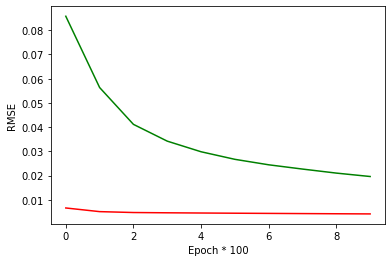

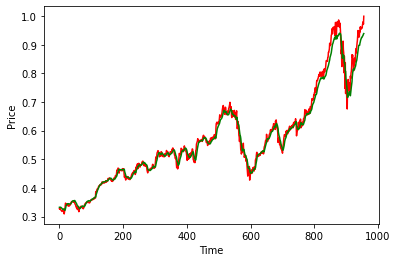

In [13]:
plt.figure(1)
plt.plot(trainerrors, 'red')
plt.plot(testerrors, 'green')
plt.xlabel("Epoch * 100")
plt.ylabel('RMSE')
 
plt.figure(2)
plt.plot(testB, 'red')
plt.plot(testpredict, 'green')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

In [14]:
redata = np.array([a[len(a)-seq_len : ]])
print("최근 데이터의 shape :", redata.shape)
print("최근 데이터 : ", redata)

최근 데이터의 shape : (1, 252, 6)
최근 데이터 :  [[[0.56112719 0.57747464 0.55889115 0.5721262  0.56534977 0.01129697]
  [0.57714225 0.58789952 0.57656812 0.57946898 0.57260595 0.00887848]
  [0.58635847 0.58980321 0.58255113 0.58620737 0.57926486 0.00926427]
  ...
  [0.97857611 0.98322956 0.97144483 0.97996606 0.97996606 0.00882532]
  [0.97776028 0.98147692 0.96685187 0.97150532 0.97150532 0.00653189]
  [0.97461767 1.         0.97425509 0.99924457 0.99924457 0.01325018]]]


In [15]:
def re_mm_scaling(org_x, x):
    org_x = np.asarray(org_x)
    x = np.asarray(x)
    return (x * (org_x.max() - org_x.min() + 1e-7)) + org_x.min()

In [16]:
testpredict = sess.run(hypo, feed_dict={A: redata})
 
print("test predict : ", testpredict[0])
testpredict = re_mm_scaling(price,testpredict) 
print("다음날 주가(예축) : ", testpredict[0]) 
print("다음날 주가(실제) : ",[333.46])

test predict :  [0.9438083]
다음날 주가(예축) :  [313.154]
다음날 주가(실제) :  [333.46]
